#Spam Detection task4

Build an AI model that can classify SMS messages as spam or
legitimate. Use techniques like TF-IDF or word embeddings with
classifiers like Naive Bayes, Logistic Regression, or Support Vector

Machines to identify spam messages

# Contents
>  1. Importing the text data
>  2. Exploratory Data Analysis (EDA)
>  3. Data preprocessing
>  4. Model training & evaluation

# Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


In [4]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('fast')
sns.set_style("ticks")

import string
import re
import nltk

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# nltk.data.path.append('.\\nltk_data')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

from sklearn.model_selection import GridSearchCV

pd.__version__, np.__version__, sns.__version__

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


('1.5.3', '1.23.5', '0.12.2')

### NLTK Dependencies

**Punkt:** Word tokenization

**Wordnet:** Corpus processing

**Stopwords:** Filtering unhelpful, frequent words

# Importing the text data

In [5]:
df = pd.read_csv("/content/drive/MyDrive/spam.csv", encoding="latin-1")
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [6]:
df.dropna(how='any', inplace=True, axis=1)
df.columns = ['type', 'text']

# Binary target column
df['target'] = df['type'].map({'ham':0, 'spam':1})

print(df.shape)
df.head(10)

(5572, 3)


,type,text,target
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0
5,spam,FreeMsg Hey there darling it's been 3 week's n...,1
6,ham,Even my brother is not like to speak with me. ...,0
7,ham,As per your request 'Melle Melle (Oru Minnamin...,0
8,spam,WINNER!! As a valued network customer you have...,1
9,spam,Had your mobile 11 months or more? U R entitle...,1


Our starting point is `5572` messages labeled spam or not spam. The `spam` column is represents our target vector numerically.

# Exploratory Data Analysis (EDA)

In [7]:
df.describe()

,target
count,5572.000000
mean,0.134063
std,0.340751
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [8]:
# Check for duplicates
print('Number of duplicate entries:',
      df.duplicated().sum())

Number of duplicate entries: 403


The data has `747` spam messages and `4825` not spam (ham) messages and `403` of the messages are duplicates.

Text(0.5, 1.0, 'Target Distribution')

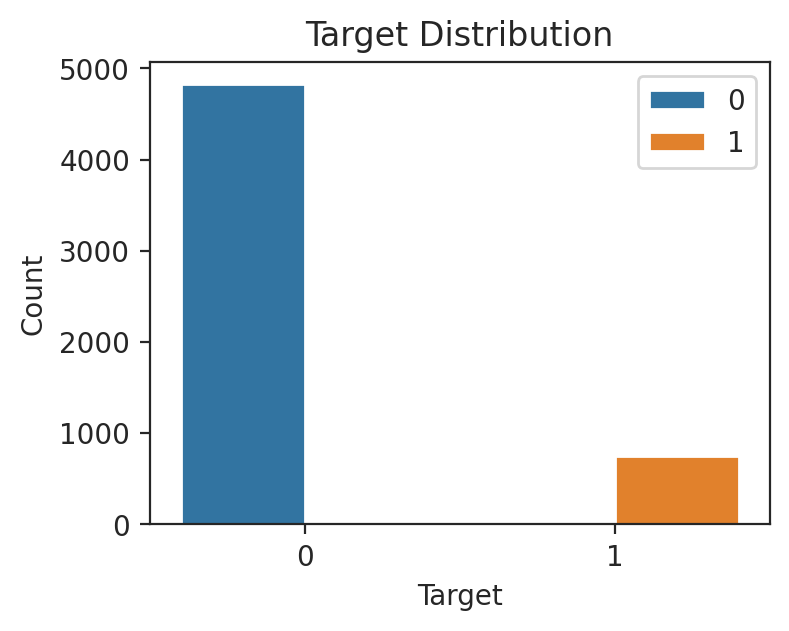

In [9]:
plt.figure(figsize=(4,3), dpi=200)

sns.barplot(x=df['target'].value_counts().index,
            y=df['target'].value_counts(),
            hue=df['target'].value_counts().index)

plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Target Distribution')

In [10]:
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
df['char_count'] = df['text'].apply(len)

df.head()

,type,text,target,word_count,char_count
0,ham,"Go until jurong point, crazy.. Available only ...",0,20,111
1,ham,Ok lar... Joking wif u oni...,0,6,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,28,155
3,ham,U dun say so early hor... U c already then say...,0,11,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,13,61


Text(0.5, 0, 'Word Count')

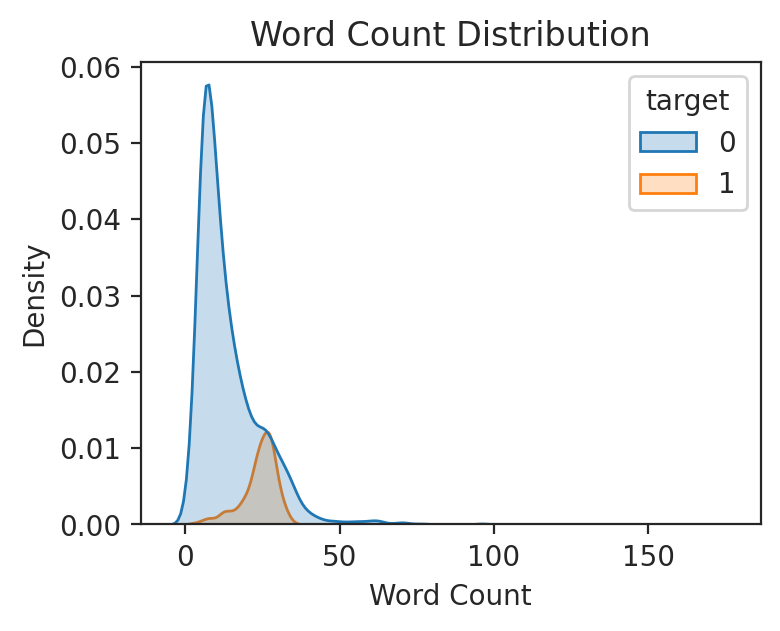

In [11]:
plt.figure(figsize=(4,3), dpi=200)

sns.kdeplot(data=df, x='word_count',
            hue='target',
            fill=True)

plt.title('Word Count Distribution')
plt.xlabel('Word Count')


Text(0.5, 0, 'Character Count')

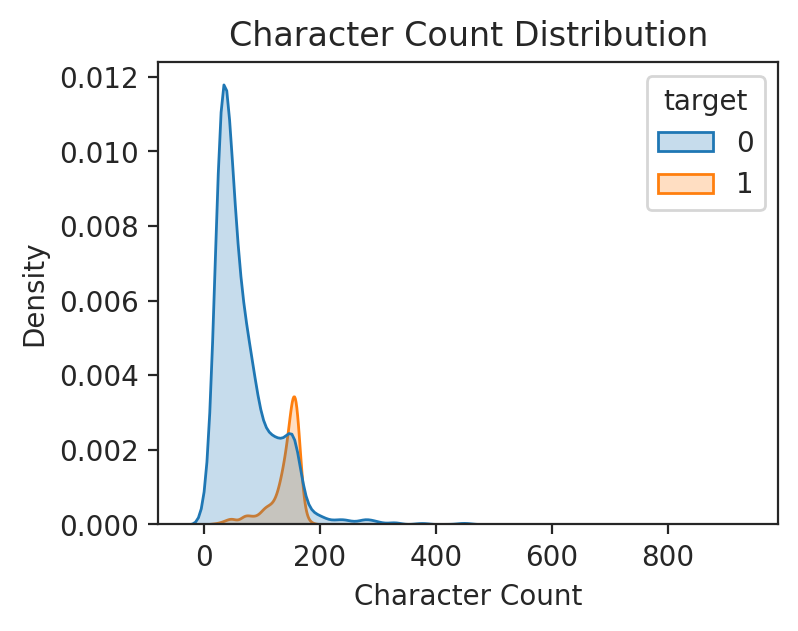

In [12]:
plt.figure(figsize=(4,3), dpi=200)

sns.kdeplot(data=df, x='char_count',
            hue='target',
            fill=True)

plt.title('Character Count Distribution')
plt.xlabel('Character Count')


In [13]:
print(df.groupby('target').describe()['char_count'])

         count        mean        std   min    25%    50%    75%    max
target                                                                 
0       4825.0   71.023627  58.016023   2.0   33.0   52.0   92.0  910.0
1        747.0  138.866131  29.183082  13.0  132.5  149.0  157.0  224.0


We have engineered two new features, `word_count` and `char_count`. From a quick examination of their respective distributions, it is clear that spam messages are typically longer with a higher average word and character count and a smaller standard deviation in boths cases.

# Data Preprocessing

A prerequisite to training and evaluating models is ensuring that the data is in some numerical format which the algorithms can understand. Recall that we want to map some feature matrix to the target vector.

$$g\left(X\right) = y$$

The `target` column is the numerical representation of `type` and will be our $y$ vector. Currently, our feature matrix, $X$, has three features: `text`, `word_count` and `char_count`. The count-type features are already numeric, but `text` is string data type, which we cannot use in our feature matrix.

There are various different methods of converting string data to numeric vector format.

# Cleaning the data

In [14]:
punctuations = string.punctuation

In [15]:
def remove_punctuations(text):
    for punctuation in punctuations:
        text = text.replace(punctuation, '')
    return text

df['cleaned_text'] = df['text'].apply(remove_punctuations)
df.head()

,type,text,target,word_count,char_count,cleaned_text
0,ham,"Go until jurong point, crazy.. Available only ...",0,20,111,Go until jurong point crazy Available only in ...
1,ham,Ok lar... Joking wif u oni...,0,6,29,Ok lar Joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,28,155,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...,0,11,49,U dun say so early hor U c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,13,61,Nah I dont think he goes to usf he lives aroun...


Great -- we have removed the following punctuation from the text, `!"#$%&'()*+,-./:;<=>?@[\]^_`{|}`~`. However, some of the messages may still contain links, numbers and linebreaks which we want to remove. To do this, we can use regular expressions (regex) thanks to the `re` package.

In [16]:
def remove_numbers(text):
    text = re.sub(r'\d+', '', text)
    return text

def remove_links(text):
    text = re.sub(r'http\S+', '', text)
    return text

def remove_linebreaks(text):
    text = re.sub(r'\n', '', text)
    return text

def clean_text(text):
    text = remove_punctuations(text)
    text = remove_numbers(text)
    text = remove_links(text)
    text = remove_linebreaks(text)
    return text

df['cleaned_text'] = df['text'].apply(clean_text).str.lower()

df.head()

,type,text,target,word_count,char_count,cleaned_text
0,ham,"Go until jurong point, crazy.. Available only ...",0,20,111,go until jurong point crazy available only in ...
1,ham,Ok lar... Joking wif u oni...,0,6,29,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,28,155,free entry in a wkly comp to win fa cup final...
3,ham,U dun say so early hor... U c already then say...,0,11,49,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,13,61,nah i dont think he goes to usf he lives aroun...


# Tokenising the data

> **Note:** Due to technical difficulties with using `nltk.download`, I have manually sourced the nltk `wordnet`, `punkt` and `stopwords` dependencies. If you want to use these files be sure to first run `nltk.data.path.append('//nltk_data')`.

Tokenising the text data essentially splits the text into smaller units, such as words or sentences. The `NLTK` package has two really useful packages, `word_tokenize` and `sent_tokenize` for tokenizing text into words and sentences, respectively.

In [17]:
word_tokenize(df['cleaned_text'][1])

['ok', 'lar', 'joking', 'wif', 'u', 'oni']

In [18]:
def tokenize(text):
    return nltk.word_tokenize(text)

df['tokenized_text'] = df['cleaned_text'].apply(tokenize)

df.head()

,type,text,target,word_count,char_count,cleaned_text,tokenized_text
0,ham,"Go until jurong point, crazy.. Available only ...",0,20,111,go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o..."
1,ham,Ok lar... Joking wif u oni...,0,6,29,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,28,155,free entry in a wkly comp to win fa cup final...,"[free, entry, in, a, wkly, comp, to, win, fa, ..."
3,ham,U dun say so early hor... U c already then say...,0,11,49,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t..."
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,13,61,nah i dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l..."


There are various ways of tokenizing data, including Python's built-in `split` command and packages, such as `NLTK`, `Keras`, `Gensim` and `spaCy`.

# Stopwords

Some words are insignificant are highly frequent in the English language. We call such words `stop words`. These words can be troublesome during the training of NLP models, hence we remove them. No universal list of stop words has been agreed upon; however, there are some popular compilations, such as <a href="https://gist.github.com/sebleier/554280">`NLTK`'s collection</a>.

We will use `NLTK` to remove stop words from our text.

In [19]:
stop_words = stopwords.words('english')

print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

Given that we're working with SMS data, there is likely some negligently-spelt words, for example "u" (you), "im" (I'm) and "c" (see). See here: <a href="https://en.wikipedia.org/wiki/SMS_language">SMS Language</a>.

Because `stop_words` is just a list we can append it with any necessary additions.

In [20]:
more_stopwords = ['u', 'im', 'c', 'ü', 'ur', '4', '2', 'dont', 'doin', 'ure']
stop_words = stop_words + more_stopwords

In [21]:
def remove_stopwords(text):
    text = ' '.join(word for word in text if word not in stop_words).split(' ')
    return text

df['tokenized_text'] = df['tokenized_text'].apply(remove_stopwords)

df.head()

,type,text,target,word_count,char_count,cleaned_text,tokenized_text
0,ham,"Go until jurong point, crazy.. Available only ...",0,20,111,go until jurong point crazy available only in ...,"[go, jurong, point, crazy, available, bugis, n..."
1,ham,Ok lar... Joking wif u oni...,0,6,29,ok lar joking wif u oni,"[ok, lar, joking, wif, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,28,155,free entry in a wkly comp to win fa cup final...,"[free, entry, wkly, comp, win, fa, cup, final,..."
3,ham,U dun say so early hor... U c already then say...,0,11,49,u dun say so early hor u c already then say,"[dun, say, early, hor, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,13,61,nah i dont think he goes to usf he lives aroun...,"[nah, think, goes, usf, lives, around, though]"


# Stemming

`Stemming` is a technique to reduce words to their root or base form. The motivation behind stemming is to improve the performance of text classification and related NLP tasks. Stemming typically entails stripping words of prefixes, such as "ing", "ed", "s", etc.

**Example:**

creative, creating, created, creating -> create

Through stemming we are able to reduce the total vocabulary very quickly, with some sacrifice to information quality. There are also some cases when you can over-stem and under-stem, potentially misrepresenting the entire sentiment of a word!

For this particular project, we will not use a stemming technique; instead, consider `Lemmatization`, a more recent, more computationally heavy approach!

# Lemmatization

Lemmatization is similar to stemming in that it reduces words down to their canonical dictionary form. Lemmatization is more difficult and complicated to implement than stemming. The method first analyses the text and considers the context of a word before converting the word to its root. This way conversions are meaningful and likely to remain full English words (this may vary or be more difficult when working with other languages).

There are lots of different ways to perform lemmatization, but for this project we will be using `WordNet`, a database of semantic relations, as our lemmitizer, instead of training our own.

In [22]:
# Mohammed Azeem Khan's solution to Kaggle not finding wordnet
# See: https://stackoverflow.com/a/76079671

import subprocess

try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

[nltk_data] Downloading package wordnet to /kaggle/working/...


In [23]:
lemmatizer = WordNetLemmatizer()

def lemmatize(text):
    text = ' '.join(lemmatizer.lemmatize(word) for word in text).split(' ')
    return text

df['tokenized_text'] = df['tokenized_text'].apply(lemmatize)

df.head()

,type,text,target,word_count,char_count,cleaned_text,tokenized_text
0,ham,"Go until jurong point, crazy.. Available only ...",0,20,111,go until jurong point crazy available only in ...,"[go, jurong, point, crazy, available, bugis, n..."
1,ham,Ok lar... Joking wif u oni...,0,6,29,ok lar joking wif u oni,"[ok, lar, joking, wif, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,28,155,free entry in a wkly comp to win fa cup final...,"[free, entry, wkly, comp, win, fa, cup, final,..."
3,ham,U dun say so early hor... U c already then say...,0,11,49,u dun say so early hor u c already then say,"[dun, say, early, hor, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,13,61,nah i dont think he goes to usf he lives aroun...,"[nah, think, go, usf, life, around, though]"


# Summary of preprocessing

So what have we done to the data so far?

> 1. Cleaned the data using regex
> 2. Tokenized the data with NLTK punkt
> 3. Removed stopwords
> 3. Performed lemmatization using NLTK WordNet

It remains to convert our text into a numerical format which should be easier now that we've cleaned the data.

# Vectorizing the data

We want to convert the tokenized string data to numerical data. We can do this by creating an M x N matrix where M is the number of entries and N is the number of unique words.

`Document-1: He is a smart boy. She is also smart.`

`Document-2: Chirag is a smart person.`

| - | He | She | smart | boy | person
| - | - | - | - | - | - |
| D1 | 1 | 1 | 2 | 1 | 0 |
| D2 | - | - | 1 | - | 1 |


**Validation Framekwork:** `60/20/20 (%) - Train/Valdidation/Test`

In [24]:
X = df.tokenized_text
y = df.target

X_full_train, X_test, y__full_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_full_train, y__full_train, test_size=0.25, random_state=42)

X_full_train.shape, X_train.shape, X_val.shape, X_test.shape

((4457,), (3342,), (1115,), (1115,))

# CountVectorizer

`CountVectorizer` from sklearn performs the exact vectorization of the data we're looking for. One important thing to note is that, because we have already performed our own tokenizing and preprocessing of the data, we define a dummy function that will act as a placeholder for CountVectorizer's `tokenizer` and `preprocessor` options.

In [25]:
def dummy(doc):
    return doc

cv = CountVectorizer(tokenizer=dummy, preprocessor=dummy)

X_full_train_num = cv.fit_transform(X_full_train)
X_test_num = cv.transform(X_test)

X_train_num = cv.fit_transform(X_train)
X_val_num = cv.transform(X_val)

# TfidfTransformer

**TF-IDF:** Term Frequency - Inverse Document Frequency

TF-IDF is a vectorization process which scores words based on their importance relative to a body of text (a corpus). It is the most popular text scoring scheme and can be easily implemented using `scikit-learn`.

The formula for TF-IDF is as follows: $$TF \text{--} IDF = TF * IDF$$

**Term Frequency (TF):** Number of times a term appears relative to the total amount of terms

$$TF = \frac{\text{number of times a word appears}}{\text{total number of words}}$$

**Inverse Document Frequency (IDF):** More unique words receive a higher weighting than common words

$$IDF = \frac{\text{number of documents in the corpus}}{\text{number of documents the word appears in}}$$

For this project we will be implementing TF-IDF using `TfidfTransformer()` from `scikit-learn`.


In [26]:
tfidf = TfidfTransformer()

tfidf.fit_transform(X_train_num)

<3342x5880 sparse matrix of type '<class 'numpy.float64'>'
	with 27181 stored elements in Compressed Sparse Row format>

# Modelling

**Order of operations:**

> 1. Evaluate models on `train` (60%) and validate on `val` (20%) splits
> 2. Choose the best performing model and fine-tune performance
> 3. Train the final model on the extended training set (`train` + `val` = 80%) and validate on the `test` (20%) split

Given that our data is already tokenised and preprocessed using `TFidfTransformer`

In [27]:
models = {
    'RF': RandomForestClassifier(),
    'NB': MultinomialNB(),
    'LR': LogisticRegression(),
    'SVM': SVC(),
    'SGD': SGDClassifier(),
    'KNN': KNeighborsClassifier()
}

model_scores = {}

def train_eval_model(model, X_train, y_train, X_val):

    pipe = Pipeline([
        ('vect', CountVectorizer(tokenizer=dummy,
                                 preprocessor=dummy)),
        ('tfidf', TfidfTransformer()),
        ('model', model)
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_val)

    return y_pred


for name, model in models.items():

    y_pred = train_eval_model(model, X_train, y_train, X_val)

    scores = {'Accuracy' : f'{accuracy_score(y_val, y_pred):.2f}',
           'AUC' : f'{roc_auc_score(y_val, y_pred):.2f}',
           'F1' : f'{f1_score(y_val, y_pred):.2f}'}

    model_scores[name] = scores

model_scores

{'RF': {'Accuracy': '0.98', 'AUC': '0.89', 'F1': '0.87'},
 'NB': {'Accuracy': '0.97', 'AUC': '0.84', 'F1': '0.82'},
 'LR': {'Accuracy': '0.97', 'AUC': '0.84', 'F1': '0.81'},
 'SVM': {'Accuracy': '0.98', 'AUC': '0.89', 'F1': '0.88'},
 'SGD': {'Accuracy': '0.98', 'AUC': '0.93', 'F1': '0.89'},
 'KNN': {'Accuracy': '0.97', 'AUC': '0.87', 'F1': '0.85'}}

**Stochastic Gradient Descent (SGD)** is the highest-scoring model in terms of accuracy and AUC; hence, will be the model of choice for fine-tuning.

# Tuning the model

In [28]:
y_pred = train_eval_model(SGDClassifier(),
                          X_full_train,
                          y__full_train,
                          X_test)

scores = {'Accuracy' : f'{accuracy_score(y_test, y_pred):.3f}',
           'AUC' : f'{roc_auc_score(y_test, y_pred):.3f}',
           'F1' : f'{f1_score(y_test, y_pred):.3f}'}

scores

{'Accuracy': '0.978', 'AUC': '0.934', 'F1': '0.916'}

In [ ]:
# param_grid = {
#     'tfidf__use_idf': (True, False),
#     'model__alpha': (1e-2, 1e-3),
#     'model__penalty': ('l2', 'elasticnet', 'none'),
#     'model__max_iter': (5, 10, 50, 100, 500, 1000),
#     'model__learning_rate': ('optimal', 'adaptive', 'invscaling'),
#     'model__loss': ('hinge', 'log', 'modified_huber'),
#     'model__random_state': (42,)
# }

# pipe = Pipeline([
#         ('vect', CountVectorizer(tokenizer=dummy,
#                                  preprocessor=dummy)),
#         ('tfidf', TfidfTransformer()),
#         ('model', SGDClassifier())
#     ])

# gs_clf = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1).fit(X_full_train, y__full_train)

# gs_best = gs_clf.best_params_
# print(f'{gs_clf.best_score_:.3f}')

In [ ]:
gs_best = {'model__alpha': 0.001,
 'model__learning_rate': 'optimal',
 'model__loss': 'modified_huber',
 'model__max_iter': 5,
 'model__penalty': 'l2',
 'model__random_state': 42,
 'tfidf__use_idf': False}

# Final Model

In [29]:
model = SGDClassifier(learning_rate='optimal',
                      loss='modified_huber',
                      max_iter=10,
                      random_state=42)

pipe = Pipeline([
    ('vect', CountVectorizer(tokenizer=dummy,
                            preprocessor=dummy)),
    ('tfidf', TfidfTransformer()),
    ('model', model)
])

pipe.fit(X_full_train, y__full_train)

y_pred = pipe.predict(X_test)

scores = {'Accuracy' : f'{accuracy_score(y_test, y_pred):.3f}',
          'AUC' : f'{roc_auc_score(y_test, y_pred):.3f}',
          'F1' : f'{f1_score(y_test, y_pred):.3f}'}

scores

{'Accuracy': '0.979', 'AUC': '0.935', 'F1': '0.919'}